In [1]:
import numpy as np
import pandas as pd

---
### Setting up basic matrices:
The Pauli matrices are the four 2x2 matrices, I, X, Y, Z.
For this example, we have a 4x4 Hamiltonian that is decomposed into IZ, ZI, XX, YY, and ZZ terms (this notation is not matrix multiplication--it is a Kronecker product, which takes two 2x2 matrices and gives a 4x4 matrix).

In [2]:
I = np.eye(2)
X = np.array([[0., 1.],
              [1., 0.]])
Y = np.array([[0., -1j],
              [1j, 0.]])
Z = np.array([[1., 0.],
              [0., -1.]])

In [3]:
IZ = np.kron(I, Z)
print(IZ)

[[ 1.  0.  0.  0.]
 [ 0. -1.  0. -0.]
 [ 0.  0.  1.  0.]
 [ 0. -0.  0. -1.]]


In [4]:
ZI = np.kron(Z, I)
print(ZI)

[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0. -1. -0.]
 [ 0.  0. -0. -1.]]


In [5]:
XX = np.kron(X, X)
print(XX)

[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


In [6]:
YY = np.kron(Y, Y)
print(YY)

[[ 0.+0.j  0.-0.j  0.-0.j -1.+0.j]
 [ 0.+0.j  0.+0.j  1.-0.j  0.-0.j]
 [ 0.+0.j  1.-0.j  0.+0.j  0.-0.j]
 [-1.+0.j  0.+0.j  0.+0.j  0.+0.j]]


In [7]:
ZZ = np.kron(Z, Z)
print(ZZ)

[[ 1.  0.  0.  0.]
 [ 0. -1.  0. -0.]
 [ 0.  0. -1. -0.]
 [ 0. -0. -0.  1.]]


----
### Hamiltonian
We consider the Hamiltonian:
$H = IZ + ZI - XX - YY + ZZ$

In [8]:
H = IZ + ZI - XX - YY + ZZ
print(H)

[[ 3.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j -2.+0.j  0.+0.j]
 [ 0.+0.j -2.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j -1.+0.j]]


---
### Measuring an observable
An observable is a matrix that we can measure against a state $\vec{\psi}$. The Hamiltonian is an observable. So are the Pauli terms that it is written as a sum of.

To measure some observable matrix $M$ with respect to a state $\vec{\psi}$, we just compute $\vec{\psi}^{\dagger} M \vec{\psi}$. The $\dagger$ means conjugate transpose = transpose the matrix and then take complex conjugates. In this specific example, all the numbers are real, so it happens to be the same as an ordinary matrix transpose.

Here is a helper method that does everything for us:

In [2]:
def expected_value(M, state):
    return np.asmatrix(state).getH() @ M @ state  # .getH() does conjugate tranpose

---
### Let's try for $\vec{\psi} = [0, 1, 0, 0]^T$

In [10]:
state = np.array([[0.], [1.], [0.], [0.]])

#### Method 1: measure $H$ directly
A quantum computer can't actually measure $H$ directly, but let's just check what the answer should be.

In [11]:
print(expected_value(H, state))

[[-1.+0.j]]


#### Method 2: linearity of expectation
A quantum computer can compute the Pauli observables though. So let's use linearity of expectation instead:

In [12]:
IZ_expectation = expected_value(IZ, state)
ZI_expectation = expected_value(ZI, state)
XX_expectation = expected_value(XX, state)
YY_expectation = expected_value(YY, state)
ZZ_expectation = expected_value(ZZ, state)
print(IZ_expectation, ZI_expectation, XX_expectation, YY_expectation, ZZ_expectation)
print(IZ_expectation + ZI_expectation - XX_expectation - YY_expectation + ZZ_expectation)

[[-1.]] [[1.]] [[0.]] [[0.+0.j]] [[-1.]]
[[-1.+0.j]]


Yup, we got -1 both ways!

---
### Variances / Covariances

In [3]:
def variance(M, state):
    # variances is <M^2> - <M>^2
    return expected_value(M @ M, state) - expected_value(M, state) ** 2

def covariance(M_1, M_2, state):
    return expected_value(M_1 @ M_2, state) - expected_value(M_1, state) * expected_value(M_2, state)

The cells below show that:
- Var(H) = 4
- Var(IZ) + Var(ZI) + Var(XX) + Var(YY) + Var(ZZ) = 2 -- not equal because we need to account for covariances
- the summed covariances do indeed equal 4. Note that the XX and ZZ

In [14]:
variance(H, state)

matrix([[4.+0.j]])

In [15]:
variance(IZ, state)

matrix([[0.]])

In [16]:
variance(ZI, state)

matrix([[0.]])

In [17]:
variance(XX, state)

matrix([[1.]])

In [18]:
variance(YY, state)

matrix([[1.+0.j]])

In [19]:
variance(ZZ, state)

matrix([[0.]])

In [20]:
terms, coefficients = [IZ, ZI, XX, YY, ZZ], [1., 1., -1., -1., 1.]
total = np.array([[0.+0.j]])
for i in range(5):
    for j in range(5):
        cov = covariance(terms[i], terms[j], state)
        if cov != 0:
            print(cov, i, j)
            total += (coefficients[i] * coefficients[j] * covariance(terms[i], terms[j], state))
print('Variance from summed covariances is %s' % total)

[[1.]] 2 2
[[1.+0.j]] 2 3
[[1.+0.j]] 3 2
[[1.+0.j]] 3 3
Variance from summed covariances is [[4.+0.j]]


----
### Different State, $\vec{\psi} = [0.43 - 0.16i, -0.49, 0.44i, -0.39 + 0.46i]$

In [21]:
state = np.array([[0.43 - 0.16j], [-0.49], [0.43j], [-0.39 + 0.46j]])

In [22]:
variance(H, state)

matrix([[4.35848816-2.22044605e-16j]])

In [23]:
variance(IZ, state), variance(ZI, state), variance(-XX, state), variance(-YY, state), variance(ZZ, state)

(matrix([[0.95576944+0.j]]),
 matrix([[0.989596+0.j]]),
 matrix([[0.76629724+6.6974204e-18j]]),
 matrix([[0.76629724+0.j]]),
 matrix([[0.97693936+0.j]]))

In [24]:
print(covariance(IZ, ZI, state))
print(covariance(IZ, ZZ, state))
print(covariance(ZI, ZZ, state))
print(covariance(-XX, -YY, state))
print(covariance(-XX, ZZ, state))
print(covariance(-YY, ZZ, state))

[[0.1287768+0.j]]
[[-0.06690672+0.j]]
[[-0.1937784+0.j]]
[[0.08370276-3.3487102e-18j]]
[[0.41059608+1.03528297e-18j]]
[[-0.41059608+6.9388939e-18j]]


In [25]:
# Setting 1 (measure all terms separately) would require a number of state preparations equal to:
5 * (0.95576944 + 0.989596 + 0.76629724 + 0.76629724 + 0.97693936)

22.2744964

In [26]:
# Setting 2 (measure {XX}, {YY, ZZ}, {IZ, ZI}) would require a number of state preparations equal to:
3 * (0.95576944 + 0.989596 + 0.76629724 + 0.76629724 + 0.97693936 + 2*0.08370276 + 2*0.1287768)

14.6395752

In [27]:
# Setting 3 (measure {XX, YY, ZZ}, {IZ, ZI}) would require a number of state preparations equal to:
2 * (0.95576944 + 0.989596 + 0.76629724 + 0.76629724 + 0.97693936 + 2*0.08370276 + 2*0.41059608 + 2*-0.41059608 + 2*0.1287768)

9.7597168

### Programatically finding optimal groupings

In [4]:
# Functions for parsing from strings to matrices
import qutip

def _to_matrix(pauli_char):
    if pauli_char == 'X':
        return qutip.sigmax()
    elif pauli_char == 'Y':
        return qutip.sigmay()
    elif pauli_char == 'Z':
        return qutip.sigmaz()
    return qutip.identity(2)
    
def pauli_string_to_matrix(pauli_string, sign=1):
    if pauli_string[0] == '-':
        sign = -1
        pauli_string = pauli_string[1:]
    matrices = []
    for char in pauli_string:
        matrices.append(_to_matrix(char))
    return sign*qutip.tensor(matrices)

pauli_string_to_matrix('-XX')

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.  0.  0. -1.]
 [ 0.  0. -1.  0.]
 [ 0. -1.  0.  0.]
 [-1.  0.  0.  0.]]

In [5]:
def variance_grouping(grouping, state):
    """
    Computes the variance of a grouping, via the formula
             Var(A+B) = Var(A) + Var(B) + 2*Cov(A,B)
    Inputs:
       Grouping (as a list, e.g. [-XX, -YY, ZZ])
       State (as a np.array, e.g. np.array([[0.], [1.], [0.], [0.]]))
    """
    running_variance = sum([variance(term, state) for term in grouping])
    grouping_size = len(grouping)
    for i in range(grouping_size):
        for j in range(i):
            running_variance += 2*covariance(grouping[i], grouping[j], state)
    return(np.asscalar(running_variance))

In [6]:
# Credit to: https://stackoverflow.com/questions/19368375/set-partitions-in-python
def partition(collection):
    if len(collection) == 1:
        yield [ collection ]
        return

    first = collection[0]
    for smaller in partition(collection[1:]):
        # insert `first` in each of the subpartition's subsets
        for n, subset in enumerate(smaller):
            yield smaller[:n] + [[ first ] + subset]  + smaller[n+1:]
        # put `first` in its own subset 
        yield [ [ first ] ] + smaller


In [7]:
def grouping_is_pairwise_commuting(grouping_to_test):
    """
    Computes whether all pairs within a grouping commute (in a general sense).
    Inputs:
        grouping_to_test: a single list of *strings*, e.g. ["-XX", "-YY", "ZZ", "IZ", "ZI"]
    Returns:
        True if all pairs commute; False if not all pairs commute
    """
    evaled_grouping_to_test = [pauli_string_to_matrix(term).full() for term in grouping_to_test]
    running_sum = 0
    for i in range(len(evaled_grouping_to_test)):
        for j in range(i+1, len(evaled_grouping_to_test)):
            # RHS evaluates to 1 if non-commuting, 0 if commuting
            running_sum += not np.array_equal(evaled_grouping_to_test[i] @ evaled_grouping_to_test[j],
                               evaled_grouping_to_test[j] @ evaled_grouping_to_test[i])
    # sum will be 0 iff all pairs commute
    return(running_sum == 0)

def is_valid_partition(partition):
    """
    Computes whether all groupings within a partition are pairwise commuting.
    Inputs:
        partition: a list of lists of strings, e.g. [['-XX', '-YY'], ['ZZ', 'IZ', 'ZI']]
    Outputs:
        1 if all groupings within the partition are pairwise commuting. Else 0.
    """
    return(sum([grouping_is_pairwise_commuting(grouping) for grouping in partition]) == len(partition))

In [8]:
def calculate_expected_state_preps_valid_partitions(term_set, state):
    """
    Computes the expected number of state preparations given every valid partition of a set of terms.
    A valid partition is one in which all groupings are pairwise commuting.
    Inputs:
        term_set: list of *strings*, e.g. ["-XX", "-YY", "ZZ", "IZ", "ZI"]
        state: as a np.array, e.g. np.array([[0.], [1.], [0.], [0.]]))
    """
    evaled_term_set = [pauli_string_to_matrix(term).full() for term in term_set]
    partition_list = []
    expected_state_prep_list = []
    for pp in partition(list(range(len(term_set)))):
        partition_list.append([list(np.array(term_set)[grouping]) for grouping in pp])
        expected_state_prep_list.append(sum([variance_grouping(np.array(evaled_term_set)[indices], state)*len(pp) for indices in pp]))
    partition_df = pd.DataFrame({'partition': partition_list, 'expected_state_preps': expected_state_prep_list}).sort_values(by=["expected_state_preps"])
    # Eliminate invalid partitions that contain groupings that are non-pairwise-computing.
    return(partition_df[partition_df['partition'].apply(lambda partition: is_valid_partition(partition))])

# Aspuru-Guzik example
test_term_set = ["-XX", "-YY", "ZZ", "IZ", "ZI"]
state = np.array([[0], [1], [0], [0]])

partition_list = calculate_expected_state_preps_valid_partitions(test_term_set, state)
partition_list


,partition,expected_state_preps
7,"[[-XX], [-YY, ZZ], [IZ, ZI]]",(6+0j)
12,"[[-YY], [-XX, ZZ], [IZ, ZI]]",(6+0j)
4,"[[-XX], [-YY], [ZZ, IZ, ZI]]",(6+0j)
48,"[[-YY], [-XX, ZZ], [IZ], [ZI]]",(8+0j)
38,"[[-XX], [-YY, ZZ], [IZ], [ZI]]",(8+0j)
34,"[[-XX], [-YY], [IZ], [ZZ, ZI]]",(8+0j)
14,"[[-XX], [-YY], [ZZ], [IZ, ZI]]",(8+0j)
24,"[[-XX], [-YY], [ZZ, IZ], [ZI]]",(8+0j)
2,"[[-XX, -YY], [ZZ, IZ, ZI]]",(8+0j)
5,"[[-XX, -YY, ZZ], [IZ, ZI]]",(8+0j)


In [9]:
# Helper function: print all pairwise covariances across commuting terms
def pairwise_covariances_commuting_terms(term_set, state):
    covariance_list = []
    evaled_term_set = [pauli_string_to_matrix(term).full() for term in term_set]
    for i in range(len(evaled_term_set)):
        for j in range(i+1, len(evaled_term_set)):
            # evaluates to 1 if commuting, 0 if non-commuting
            if np.array_equal(evaled_term_set[i] @ evaled_term_set[j],
                               evaled_term_set[j] @ evaled_term_set[i]):
                covariance_list.append([term_set[i], term_set[j], covariance(evaled_term_set[i], evaled_term_set[j], state).item()])
    return(pd.DataFrame(covariance_list, columns=["term 1", "term 2", "covariance"]))

In [16]:
pairwise_covariances_commuting_terms(test_term_set, state)

,term 1,term 2,covariance
0,-XX,-YY,(1+0j)
1,-XX,ZZ,0j
2,-YY,ZZ,0j
3,ZZ,IZ,0j
4,ZZ,ZI,0j
5,IZ,ZI,0j


In [10]:
def expected_state_preps_for_list_of_states(test_term_set, state_list):
    """
    Given a *list* of possible states, calculates the number of
    expected state preparations for every state in that list,
    for every valid partition.
    Input:
        test_term_set, as a list of strings: e.g. ['-XX', '-YY', 'ZZ', 'IZ', 'ZI']
        state_list, as a list of np arrays, e.g. [qutip.basis(4,i).full() for i in range(4)]
    Output:
        Pandas dataframe with:
            - partition
            - expected state preps over every state
            - mean number of state preps, given a uniform probability of any of the states
            - variance of state preps, given a uniform probability of any of the states
    """
    n_states = len(state_list)
    base_df = calculate_expected_state_preps_valid_partitions(test_term_set, state_list[0])
    for state in state_list[1:]:
        # Merge the next calculation in the list, based on index
        base_df = pd.merge(base_df,
                 calculate_expected_state_preps_valid_partitions(test_term_set, state).iloc[:,1],
                 left_index = True, right_index = True)
    # rename columns to state0, state1, etc.
    base_df.columns.values[1:] = ["{}{}".format(a_,b_) for a_, b_ in zip(['state']*n_states, [str(i) for i in range(n_states)])]
    base_df['row_mean'] = base_df.iloc[:,1:].mean(axis=1)
    base_df['row_var'] = base_df.iloc[:,1:].var(axis=1)
    base_df = base_df.sort_values(by=["row_mean"])
    # round the real and imaginary parts to two decimal places
    base_df.iloc[:,1:] = base_df.iloc[:,1:].apply(lambda x: np.around(x, decimals=2), axis=0)
    return(base_df)

In [17]:
# basis states
basis_states_4 = [qutip.basis(4,i).full() for i in range(4)]
basis_states_mean_state_preps = expected_state_preps_for_list_of_states(test_term_set, basis_states_4)
basis_states_mean_state_preps

/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial)


,partition,state0,state1,state2,state3,row_mean,row_var
5,"[[-XX, -YY, ZZ], [IZ, ZI]]",0j,(8+0j),(8+0j),0j,(4+0j),16.0
2,"[[-XX, -YY], [ZZ, IZ, ZI]]",0j,(8+0j),(8+0j),0j,(4+0j),16.0
35,"[[-XX, -YY, ZZ], [IZ], [ZI]]",0j,(12+0j),(12+0j),0j,(6+0j),36.0
31,"[[-XX, -YY], [IZ], [ZZ, ZI]]",0j,(12+0j),(12+0j),0j,(6+0j),36.0
21,"[[-XX, -YY], [ZZ, IZ], [ZI]]",0j,(12+0j),(12+0j),0j,(6+0j),36.0
11,"[[-XX, -YY], [ZZ], [IZ, ZI]]",0j,(12+0j),(12+0j),0j,(6+0j),36.0
4,"[[-XX], [-YY], [ZZ, IZ, ZI]]",(6+0j),(6+0j),(6+0j),(6+0j),(6+0j),0.0
12,"[[-YY], [-XX, ZZ], [IZ, ZI]]",(6+0j),(6+0j),(6+0j),(6+0j),(6+0j),0.0
7,"[[-XX], [-YY, ZZ], [IZ, ZI]]",(6+0j),(6+0j),(6+0j),(6+0j),(6+0j),0.0
47,"[[-XX, -YY], [ZZ], [IZ], [ZI]]",0j,(16+0j),(16+0j),0j,(8+0j),64.0


In [20]:
# Are the ideal partitions the same with random kets?
random_state_list = [qutip.rand_ket(4).full() for i in range(4)]
random_states_mean_state_preps = expected_state_preps_for_list_of_states(test_term_set, random_state_list)
# round the real and imaginary parts to two decimal places
random_states_mean_state_preps.iloc[:,1:] = random_states_mean_state_preps.iloc[:,1:].apply(lambda x: np.around(x, decimals=2), axis=0)
random_states_mean_state_preps

/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial)


,partition,state0,state1,state2,state3,row_mean,row_var
2,"[[-XX, -YY], [ZZ, IZ, ZI]]",(9.28+0j),(10.04+0j),(11.68+0j),(7.36-0j),(9.59+0j),2.41
5,"[[-XX, -YY, ZZ], [IZ, ZI]]",(12.31-0j),(7.66+0j),(10.17+0j),(9.22-0j),(9.84-0j),2.83
7,"[[-XX], [-YY, ZZ], [IZ, ZI]]",(16.65+0j),(9.99+0j),(12.51+0j),(9.77-0j),(12.23-0j),7.67
11,"[[-XX, -YY], [ZZ], [IZ, ZI]]",(12.66+0j),(14.28+0j),(13.87+0j),(14.12-0j),(13.73+0j),0.40
4,"[[-XX], [-YY], [ZZ, IZ, ZI]]",(15.79+0j),(14.46+0j),(16.69+0j),(8.49-0j),(13.86-0j),10.24
31,"[[-XX, -YY], [IZ], [ZZ, ZI]]",(12.7+0j),(13.36+0j),(14.15+0j),(15.6-0j),(13.95+0j),1.17
21,"[[-XX, -YY], [ZZ, IZ], [ZI]]",(12.07+0j),(15.73+0j),(17.98+0j),(14.08-0j),(14.97+0j),4.72
35,"[[-XX, -YY, ZZ], [IZ], [ZI]]",(17.56-0j),(11.37+0j),(15.62+0j),(16.09-0j),(15.16-0j),5.30
12,"[[-YY], [-XX, ZZ], [IZ, ZI]]",(18.22-0j),(14.58+0j),(14.96+0j),(13.09+0j),(15.21+0j),3.51
38,"[[-XX], [-YY, ZZ], [IZ], [ZI]]",(21+0j),(13.15+0j),(17.17+0j),(16.05-0j),(16.84-0j),7.91


/usr/local/lib/python3.7/site-packages/numpy/core/numeric.py:591: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:7005: ComplexWarning: Casting complex values to real discards the imaginary part
  correl = libalgos.nancorr(ensure_float64(mat), minp=min_periods)


            row_mean_x  row_mean_y
row_mean_x    1.000000    0.977048
row_mean_y    0.977048    1.000000


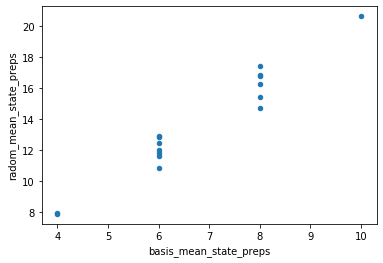

In [20]:
# Plot the number of state preps needed under the 
ax = pd.merge(basis_states_mean_state_preps,
         random_states_mean_state_preps,
         left_index=True,
         right_index=True)[['row_mean_x', 'row_mean_y']].plot.scatter(x="row_mean_x", y="row_mean_y")
ax.set_xlabel("basis_mean_state_preps")
ax.set_ylabel("radom_mean_state_preps")

# correlation between number of state preparations needed under basis states versus random states
print(pd.merge(basis_states_mean_state_preps,
         random_states_mean_state_preps,
         left_index=True,
         right_index=True)[['row_mean_x', 'row_mean_y']].corr())

# There is very high correlation between the number of state preparations needed between
# basis states and random states, for term set ['-XX', '-YY', 'ZZ', 'IZ', 'ZI'], at least.
# Could this be because only -XX and -YY ever have a positive correlation?

In [21]:
print(pd.merge(basis_states_mean_state_preps,
         random_states_mean_state_preps,
         left_index=True,
         right_index=True)[['row_mean_x', 'row_mean_y']].corr().iloc[0,1])

0.977047916070328


### Hypothesis: There is a high correlation between the # of state preps needed in basis states versus random states when the number of terms that correlate is low. Low correlation when the number of terms that correlate is high.
### Result: Not conclusive that this is true!  Between different runs, the relative agreement between mean # of state preparations in basis states versus random states varies pretty widely.

In [22]:
for state in basis_states_4:
    print(pairwise_covariances_commuting_terms(['XX', 'YY', 'ZZ', 'II',
                                                'XY', 'XZ', 'XI',
                                                'YX', 'YZ', 'YI',
                                                'ZX', 'ZY', 'ZI',
                                                'IX', 'IY', 'IZ'], state))
    
# Interestingly, across all 60 pairs of terms that commute, only 6 pairs ever correlate under a basis state:
# XX YY
# XY YX
# XZ XI
# YZ YI
# ZX IX
# ZY IY

   term 1 term 2  covariance
0      XX     YY     (-1+0j)
1      XX     ZZ          0j
2      XX     II          0j
3      XX     XI          0j
4      XX     YZ          0j
5      XX     ZY          0j
6      XX     IX          0j
7      YY     ZZ          0j
8      YY     II          0j
9      YY     XZ          0j
10     YY     YI          0j
11     YY     ZX          0j
12     YY     IY          0j
13     ZZ     II          0j
14     ZZ     XY          0j
15     ZZ     YX          0j
16     ZZ     ZI          0j
17     ZZ     IZ          0j
18     II     XY          0j
19     II     XZ          0j
20     II     XI          0j
21     II     YX          0j
22     II     YZ          0j
23     II     YI          0j
24     II     ZX          0j
25     II     ZY          0j
26     II     ZI          0j
27     II     IX          0j
28     II     IY          0j
29     II     IZ          0j
30     XY     XI          0j
31     XY     YX      (1+0j)
32     XY     YZ          0j
33     XY     

In [14]:
term_set_0_correlate = ['XX','YZ','ZZ','ZI']    # all pairwise correlations are 0
term_set_1_correlate = ['XX','YY','ZZ','ZI']    # Cov(XX,YY) = +1 under 01,10; -1 under 00,11
term_set_2_correlate = ['XY', 'YX', 'YZ', 'YI'] # Cov(XY,YX) = +1 under 00,11; -1 under 01,10
                                                # Cov(YZ,YI) = +1 under 00,01; -1 under 10,11

In [24]:
for state in basis_states_4:
    print(pairwise_covariances_commuting_terms(term_set_2_correlate, state))

  term 1 term 2  covariance
0     XY     YX      (1+0j)
1     XY     YZ          0j
2     YX     YI          0j
3     YZ     YI      (1+0j)
  term 1 term 2  covariance
0     XY     YX     (-1+0j)
1     XY     YZ          0j
2     YX     YI          0j
3     YZ     YI     (-1+0j)
  term 1 term 2  covariance
0     XY     YX     (-1+0j)
1     XY     YZ          0j
2     YX     YI          0j
3     YZ     YI      (1+0j)
  term 1 term 2  covariance
0     XY     YX      (1+0j)
1     XY     YZ          0j
2     YX     YI          0j
3     YZ     YI     (-1+0j)


#### When 0 terms correlate, all partitions have identical number of state preps under all basis states

In [25]:
random_state_list = [qutip.rand_ket(4).full() for i in range(4)]
basis_states_mean_state_preps_0 = expected_state_preps_for_list_of_states(term_set_0_correlate, basis_states_4)
random_states_mean_state_preps_0 = expected_state_preps_for_list_of_states(term_set_0_correlate, random_state_list)

/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial)


In [26]:
basis_states_mean_state_preps_0.columns.values[1:5] = ['00', '01', '10', '11']
basis_states_mean_state_preps_0

,partition,00,01,10,11,row_mean,row_var
2,"[[XX, YZ], [ZZ, ZI]]",(4+0j),(4+0j),(4+0j),(4+0j),(4+0j),0.0
4,"[[XX], [YZ], [ZZ, ZI]]",(6+0j),(6+0j),(6+0j),(6+0j),(6+0j),0.0
11,"[[XX, YZ], [ZZ], [ZI]]",(6+0j),(6+0j),(6+0j),(6+0j),(6+0j),0.0
12,"[[YZ], [XX, ZZ], [ZI]]",(6+0j),(6+0j),(6+0j),(6+0j),(6+0j),0.0
14,"[[XX], [YZ], [ZZ], [ZI]]",(8+0j),(8+0j),(8+0j),(8+0j),(8+0j),0.0


In [27]:
random_states_mean_state_preps_0

,partition,state0,state1,state2,state3,row_mean,row_var
2,"[[XX, YZ], [ZZ, ZI]]",(6.34+0j),(7.66+0j),(4.13+0j),(7.68+0j),(6.45+0j),2.10
11,"[[XX, YZ], [ZZ], [ZI]]",(9.23+0j),(8.96+0j),(6.98+0j),(9.53+0j),(8.67+0j),1.00
12,"[[YZ], [XX, ZZ], [ZI]]",(10.46+0j),(7.23+0j),(8.71+0j),(8.59-0j),(8.75-0j),1.32
4,"[[XX], [YZ], [ZZ, ZI]]",(10.27+0j),(13.26+0j),(8.31+0j),(12.02+0j),(10.96+0j),3.47
14,"[[XX], [YZ], [ZZ], [ZI]]",(13.31+0j),(14.3+0j),(12.14+0j),(13.37+0j),(13.28+0j),0.59


In [28]:
# High correlation between the number of state preps under random states and basis states
np.corrcoef(basis_states_mean_state_preps_0['row_mean'],
           random_states_mean_state_preps_0['row_mean'])[0,1]

(0.9311802657761321+0j)

#### When 1 pair correlates AND those correlating terms are in the same grouping, then the states where they negatively correlate have low # of state preps, and the states where they positively correlate have high # of state preps.

In [25]:
basis_states_mean_state_preps_1 = expected_state_preps_for_list_of_states(term_set_1_correlate, basis_states_4)
random_states_mean_state_preps_1 = expected_state_preps_for_list_of_states(term_set_1_correlate, random_state_list)

/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial)


In [26]:
basis_states_mean_state_preps_1.columns.values[1:5] = ['00', '01', '10', '11']
basis_states_mean_state_preps_1

,partition,00,01,10,11,row_mean,row_var
2,"[[XX, YY], [ZZ, ZI]]",0j,(8+0j),(8+0j),0j,(4+0j),16.0
5,"[[XX, YY, ZZ], [ZI]]",0j,(8+0j),(8+0j),0j,(4+0j),16.0
11,"[[XX, YY], [ZZ], [ZI]]",0j,(12+0j),(12+0j),0j,(6+0j),36.0
4,"[[XX], [YY], [ZZ, ZI]]",(6+0j),(6+0j),(6+0j),(6+0j),(6+0j),0.0
7,"[[XX], [YY, ZZ], [ZI]]",(6+0j),(6+0j),(6+0j),(6+0j),(6+0j),0.0
12,"[[YY], [XX, ZZ], [ZI]]",(6+0j),(6+0j),(6+0j),(6+0j),(6+0j),0.0
14,"[[XX], [YY], [ZZ], [ZI]]",(8+0j),(8+0j),(8+0j),(8+0j),(8+0j),0.0


In [27]:
random_states_mean_state_preps_1

,partition,state0,state1,state2,state3,row_mean,row_var
5,"[[XX, YY, ZZ], [ZI]]",(2.03+0j),(9.33+0j),(6.6+0j),(9.12+0j),(6.77+0j),8.65
2,"[[XX, YY], [ZZ, ZI]]",(6.53+0j),(6.94+0j),(7.45+0j),(8.4-0j),(7.33+0j),0.49
12,"[[YY], [XX, ZZ], [ZI]]",(7.03+0j),(9.71+0j),(8.53+0j),(9.33-0j),(8.65-0j),1.05
4,"[[XX], [YY], [ZZ, ZI]]",(11.66+0j),(9.81+0j),(10.35+0j),(10.06-0j),(10.47-0j),0.51
11,"[[XX, YY], [ZZ], [ZI]]",(8.85+0j),(11.21+0j),(11.27+0j),(13.39-0j),(11.18+0j),2.58
7,"[[XX], [YY, ZZ], [ZI]]",(8.6+0j),(14.29+0j),(10.99+0j),(12.65+0j),(11.63+0j),4.42
14,"[[XX], [YY], [ZZ], [ZI]]",(14.29+0j),(14.14+0j),(13.93+0j),(14.46-0j),(14.2-0j),0.04


In [28]:
np.corrcoef(basis_states_mean_state_preps_1['row_mean'],
           random_states_mean_state_preps_1['row_mean'])[0,1]

(0.9329525990607977+0j)

#### When 2 pairs correlate, then in the state where both pairs negatively correlate, there is a low # of state preps needed.
#### In the state where both pairs positively correlate, there is a high # of state preps needed.
#### In the state where one pair is positive and one pair is negative, there is an intermediate # of state preps needed.

In [21]:
basis_states_mean_state_preps_2 = expected_state_preps_for_list_of_states(term_set_2_correlate, basis_states_4)
random_states_mean_state_preps_2 = expected_state_preps_for_list_of_states(term_set_2_correlate, random_state_list)

/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial)


In [22]:
basis_states_mean_state_preps_2.columns.values[1:5] = ['00', '01', '10', '11']
basis_states_mean_state_preps_2

,partition,00,01,10,11,row_mean,row_var
8,"[[XY, YZ], [YX, YI]]",(8+0j),(8+0j),(8+0j),(8+0j),(8+0j),0.0
2,"[[XY, YX], [YZ, YI]]",(16+0j),0j,(8+0j),(8+0j),(8+0j),32.0
10,"[[XY], [YZ], [YX, YI]]",(12+0j),(12+0j),(12+0j),(12+0j),(12+0j),0.0
12,"[[YX], [XY, YZ], [YI]]",(12+0j),(12+0j),(12+0j),(12+0j),(12+0j),0.0
4,"[[XY], [YX], [YZ, YI]]",(18+0j),(6+0j),(18+0j),(6+0j),(12+0j),36.0
11,"[[XY, YX], [YZ], [YI]]",(18+0j),(6+0j),(6+0j),(18+0j),(12+0j),36.0
14,"[[XY], [YX], [YZ], [YI]]",(16+0j),(16+0j),(16+0j),(16+0j),(16+0j),0.0


In [23]:
random_states_mean_state_preps_2

,partition,state0,state1,state2,state3,row_mean,row_var
2,"[[XY, YX], [YZ, YI]]",(4.87+0j),(5.53+0j),(6.33+0j),(5.89-0j),(5.65+0j),0.28
8,"[[XY, YZ], [YX, YI]]",(5.86+0j),(6.7-0j),(6.2-0j),(5.5-0j),(6.07-0j),0.20
12,"[[YX], [XY, YZ], [YI]]",(7.98+0j),(7.26-0j),(7.27-0j),(8.44+0j),(7.74-0j),0.25
4,"[[XY], [YX], [YZ, YI]]",(8.11+0j),(8+0j),(9.75+0j),(8.65+0j),(8.63+0j),0.48
11,"[[XY, YX], [YZ], [YI]]",(7.34+0j),(9.31+0j),(10.13+0j),(9.04-0j),(8.95+0j),1.03
10,"[[XY], [YZ], [YX, YI]]",(8.96+0j),(11.79-0j),(12.42-0j),(8.67-0j),(10.46-0j),2.77
14,"[[XY], [YX], [YZ], [YI]]",(10.86+0j),(12.01+0j),(13.86-0j),(11.81+0j),(12.13+0j),1.18


In [24]:
np.corrcoef(basis_states_mean_state_preps_2['row_mean'],
           random_states_mean_state_preps_2['row_mean'])[0,1]

(0.9361084326040777+0j)

## Lithium Hydride

### Read in Hamiltonians

In [ ]:
def construct_full_term_string(specified_term_list, n):
    """
    Given a list of terms, e.g. ['X1', 'Z3'] 
    Input:
      List of specified terms: e.g. ['X1', 'Z3']
      Number of total terms: e.g. 4
    Outputs:
      String of the full term, e.g. IXIZ
    """
    building_string = ['I']*n # default is that the position should be an I
    for term in specified_term_list:
        split_string = list(term) # e.g. list('X1') becomes ['X', '1']
        building_string[int(split_string[1])] = split_string[0]
    return(''.join(building_string))

In [ ]:
from term_grouping import parseHamiltonian
sample_h1 = parseHamiltonian('hamiltonians/sampleH1.txt')
sample_h1_terms = [construct_full_term_string(x[1], 4) for x in sample_h1]
sample_h1_coefs = [x[0] for x in sample_h1]
print(sample_h1_terms)
print(sample_h1_coefs)

lih_jw = parseHamiltonian('hamiltonians/LiH_JW.txt')
lih_jw_terms = [construct_full_term_string(x[1], 4) for x in lih_jw]
lih_jw_coefs = [x[0] for x in lih_jw]
print(lih_jw_terms)
print(lih_jw_coefs)

lih_bk = parseHamiltonian('hamiltonians/LiH_BK.txt')
lih_bk_terms = [construct_full_term_string(x[1], 4) for x in lih_bk]
lih_bk_coefs = [x[0] for x in lih_bk]
print(lih_bk_terms)
print(lih_bk_coefs)

In [ ]:
basis_states_16 = [qutip.basis(16,i).full() for i in range(16)]

In [ ]:
# TIMES OUT
# calculate_expected_state_preps_valid_partitions(lih_jw_terms, basis_states_16[0])

### Optimal groupings for LiH_BK

### Optimal groupings for LiH_JW